In [7]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt

random.seed(42)

In [8]:
env = gym.make('Taxi-v3', render_mode='ansi') # creating the taxi-v3 environment wth 'ansi' render mode, as 'human' doesnt work well in jupyter notebook
state, info = env.reset(seed=42) # we can extract the state and info from the env.reset() function

env.reset()
print(env.render()) # and then display it

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




In [9]:
# lets see how many discrete states are possible in this environment (Taxi position * passenger position * destination position)
# should be 25 * 5 * 4 = 500
print("Observation Space:", env.observation_space)

Observation Space: Discrete(500)


In [10]:
# lets see how many actions are possible in this environment
print("Action Space:", env.action_space)


Action Space: Discrete(6)


In [11]:
# each state is a number between 0 and 499.
# using "decode" we can get the taxi position, passenger position, and destination position

state, info = env.reset(seed=42)
taxi_row, taxi_col, passenger_location, destination = env.unwrapped.decode(state)

print(f"State: {state}")
print(f"Taxi Position: ({taxi_row}, {taxi_col})")
print(f"Passenger Location: {passenger_location}")
print(f"Destination: {destination}")

# to clarify, the passenger / taxi destination: 0 = R, 1 = G, 2 = Y, 3 = B, 4 = in taxi(only for passenger)


# the taxi is represented by the yellow rectangle
# the pickup locations are represented by the letters R, G, Y, B
# the passenger locations are marked


State: 386
Taxi Position: (3, 4)
Passenger Location: 1
Destination: 2


In [12]:
# Lets print the state above
print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




In [13]:
# just to make it more clear, lets print the state with the taxi and passenger actions
action_meanings = {
    0: "Move South",
    1: "Move North",
    2: "Move East",
    3: "Move West",
    4: "Pick Up Passenger",
    5: "Drop Off Passenger"
}

In [14]:
# lets see what happens when we take a random action

action = env.action_space.sample() # take a random action
print(f"Selected Action: {action_meanings[action]}") # print the selected action

new_state, reward, terminated, truncated, info = env.step(action) # take the action
print(f"New State: {new_state}") # print the new state
print(f"Reward: {reward}") # print the reward
print(f"Terminated: {terminated}") # print if the episode is terminated
print(f"Truncated: {truncated}") # print if the episode is truncated

# Decode the new state
taxi_row, taxi_col, passenger_location, destination = env.unwrapped.decode(new_state)
print(f"Taxi Position: ({taxi_row}, {taxi_col})")
print(f"Passenger Location: {passenger_location}")
print(f"Destination: {destination}")

# Render the new state
print(env.render())

Selected Action: Drop Off Passenger
New State: 386
Reward: -10
Terminated: False
Truncated: False
Taxi Position: (3, 4)
Passenger Location: 1
Destination: 2
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)



Reward:


-1 for each step to encourage shorter routes.


-10 for illegal Pickup or Drop-off.


+20 for a successful Drop-off.

Terminated:
**True** when the passenger is successfully dropped off at the destination.

Truncated:
**True** if a time limit is set and exceeded (default is 200 actions).

In [15]:
# lets see what happens when we let the agent take random actions until the episode is terminated (no real strategy)

# Define action meanings for readability
action_meanings = {
    0: "South",
    1: "North",
    2: "East",
    3: "West",
    4: "Pickup",
    5: "Drop-off"
}

# Initialize variables
total_reward = 0
steps = 0

# Start a new episode
state, info = env.reset(seed=42)
terminated = False
truncated = False

print("Initial State:")
print(env.render())

# Main loop
while not terminated and not truncated:
    # Select a random action
    action = env.action_space.sample()
    action_name = action_meanings[action]
    print(f"Step {steps + 1}: Action - {action_name}")

    # Execute the action
    next_state, reward, terminated, truncated, info = env.step(action)

    # Update total rewards and steps
    total_reward += reward
    steps += 1

    # Render the new state
    print(env.render())

    # Update the state
    state = next_state

# Display the results
print(f"Episode completed in {steps} steps with total reward {total_reward}.")
print(f"Truncated: {truncated}")


Initial State:
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


Step 1: Action - Drop-off
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Step 2: Action - Drop-off
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Step 3: Action - Drop-off
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Step 4: Action - East
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step 5: Action - Drop-off
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Step 6: Action - Pickup
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

Step 7: Action - North
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step 8: Action - North
+---------+
|R: | : :G|
| : | 

In [26]:
# Training the Agent with Q-Learning

# Get the size of the state and action spaces
state_space_size = env.observation_space.n  # 500
action_space_size = env.action_space.n      # 6

# Initialize the Q-table to zeros
q_table = np.zeros((state_space_size, action_space_size))

# Hyperparameters
alpha = 0.1     # Learning rate
gamma = 0.95     # Discount factor (how much we value future rewards. low = short sighted, high = far sighted, mid = balanced)
epsilon = 0.01      # Exploration rate #default 0.1, but epsilon * 0.99 is useful, then epsilon should be 1. this reduces exploration over time (see at the end of the loop)
num_episodes = 10000
max_steps_per_episode = 100

# Rewards for logging
rewards_all_episodes = []

# Main Q-learning algorithm
for episode in range(num_episodes):
    state, info = env.reset()
    terminated = False
    truncated = False
    total_rewards = 0

    for _ in range(max_steps_per_episode):
        # Exploration-exploitation trade-off
        if random.uniform(0, 1) < epsilon:
            # Explore: choose a random action
            action = env.action_space.sample()
        else:
            # Exploit: choose the action with the highest Q-value for the current state
            action = np.argmax(q_table[state, :])

        # Perform the action
        next_state, reward, terminated, truncated, info = env.step(action)

        # Update Q-table
        old_value = q_table[state, action] # the state we were in before the action, with the action we took
        next_max = np.max(q_table[next_state, :]) # the state we are in now, with the best action we can take after
        q_table[state, action] = old_value + alpha * (reward + gamma * next_max - old_value) #the state we were in before with the action we took, is updated with the reward we got and the best action we can take after

        # Update state
        state = next_state

        # If the episode is terminated, exit the loop
        if terminated or truncated:
            break
        
        total_rewards += reward

    # Optional: Decay epsilon to reduce exploration over time
        #epsilon = epsilon * 0.9995

    # Append total rewards for this episode
    rewards_all_episodes.append(total_rewards)

In [28]:
# testing the agent

# Set epsilon to 0 to only exploit learned values
epsilon = 0.0

state, info = env.reset() # no need for seed here :) try as many times as you like
terminated = False
truncated = False
steps = 0
total_reward = 0

print("Testing the trained agent...\n")

while not terminated and not truncated:
    action = np.argmax(q_table[state, :])
    state, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    steps += 1
    print(env.render())
    

print(f"Test completed in {steps} steps with total reward {total_reward}.")


Testing the trained agent...

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

+---------+
|R: | : :G|

Average reward per hundred episodes:
100: -171.38000000000002
200: -135.62000000000012
300: -122.71000000000005
400: -128.87000000000006
500: -110.89999999999999
600: -100.06
700: -82.80000000000004
800: -77.56000000000004
900: -65.68000000000004
1000: -55.420000000000016
1100: -52.56999999999999
1200: -31.73
1300: -30.9
1400: -25.089999999999996
1500: -23.979999999999997
1600: -19.209999999999994
1700: -16.249999999999996
1800: -15.410000000000002
1900: -16.880000000000003
2000: -14.18
2100: -13.149999999999997
2200: -14.250000000000004
2300: -13.390000000000002
2400: -12.83
2500: -12.849999999999996
2600: -13.950000000000006
2700: -12.810000000000004
2800: -13.070000000000004
2900: -12.659999999999998
3000: -12.229999999999999
3100: -12.940000000000005
3200: -12.489999999999998
3300: -11.889999999999999
3400: -12.199999999999998
3500: -12.399999999999997
3600: -12.770000000000003
3700: -13.140000000000004
3800: -12.329999999999998
3900: -12.609999999999998
4000: -12.900000000000002
4

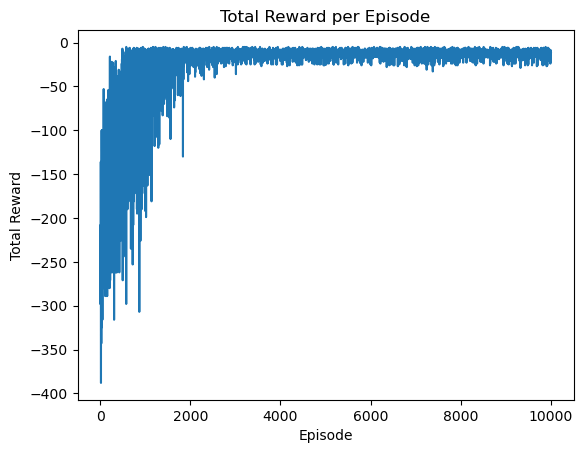

In [27]:
# Lets plot the training results

# Calculate and plot the average reward per thousand episodes
rewards_per_thousand_episodes = np.split(np.array(rewards_all_episodes), num_episodes/100)

count = 100
print("Average reward per hundred episodes:")
for r in rewards_per_thousand_episodes:
    print(f"{count}: {sum(r/100)}")
    count += 100

# Plotting
plt.plot(rewards_all_episodes)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()


In [ ]:
# We can extract the Policy from the Q-table by selecting the action with the highest Q-value for each state. This is called the Greedy Policy. This is useful for visualizing the learned policy, but only makes sense if we map the states back to the Taxi environment.
policy = np.argmax(q_table, axis=1)


Average reward over 100 episodes: 7.99


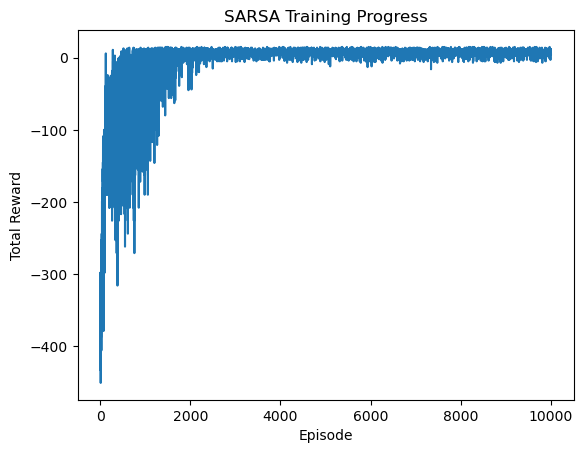

In [25]:
## SARSA

import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt


# Initialize environment
env = gym.make('Taxi-v3')

state_space_size = env.observation_space.n
action_space_size = env.action_space.n

# Initialize Q-table
q_table = np.zeros((state_space_size, action_space_size))

# Hyperparameters
num_episodes = 10000
max_steps_per_episode = 100

learning_rate = 0.1
discount_rate = 0.99

exploration_rate = 1.0
max_exploration_rate = 1.0
min_exploration_rate = 0.01
exploration_decay_rate = 0.001

rewards_per_episode = []

# SARSA Training
for episode in range(num_episodes):
    state, info = env.reset()
    done = False
    truncated = False
    
    episode_rewards = 0

    # Choose initial action
    exploration_threshold = random.uniform(0, 1)
    if exploration_threshold > exploration_rate:
        action = np.argmax(q_table[state, :])
    else:
        action = env.action_space.sample()

    for step in range(max_steps_per_episode):
        # Take action and observe next state and reward
        next_state, reward, done, truncated, info = env.step(action)
        
        # Accumulate reward
        episode_rewards += reward  # Add reward to total for this episode

        # Choose next action
        exploration_threshold = random.uniform(0, 1)
        if exploration_threshold > exploration_rate:
            next_action = np.argmax(q_table[next_state, :])
        else:
            next_action = env.action_space.sample()

        # Update Q-table
        q_table[state, action] = q_table[state, action] + learning_rate * (
            reward + discount_rate * q_table[next_state, next_action] - q_table[state, action]
        )
        

        # Transition to next state and action
        state = next_state
        action = next_action

        if done or truncated:
            break
        
    rewards_per_episode.append(episode_rewards)
    # Decay exploration rate
    exploration_rate = max(
        min_exploration_rate,
        exploration_rate * np.exp(-exploration_decay_rate * episode)
    )

# Evaluation
num_test_episodes = 100
total_rewards = 0

for episode in range(num_test_episodes):
    state, info = env.reset()
    done = False
    truncated = False
    episode_rewards = 0

    while not done and not truncated:
        action = np.argmax(q_table[state, :])
        state, reward, done, truncated, info = env.step(action)
        episode_rewards += reward

    total_rewards += episode_rewards

average_reward = total_rewards / num_test_episodes
print(f"Average reward over {num_test_episodes} episodes: {average_reward}")

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('SARSA Training Progress')
plt.show()

In [5]:
# PPO (Proximal Policy Optimization) Policy Gradient Method

import gymnasium as gym
from stable_baselines3 import PPO
import numpy as np
import matplotlib.pyplot as plt

# Ensure you have Stable Baselines3 v2.0.0 or newer installed

# Create the Taxi-v3 environment without render_mode
env = gym.make('Taxi-v3', render_mode=None)

# Instantiate the PPO model
model = PPO('MlpPolicy', env, verbose=1)

# Define the number of episodes
num_episodes = 1000

# Lists to keep track of rewards
rewards_per_episode = []

# Training Loop
for episode in range(num_episodes):
    obs, info = env.reset()
    done = False
    total_reward = 0

    while not done:
        # Get action from the model
        action, _ = model.predict(obs)
        action = action.item()  # Ensure the action is an integer
        # Take action in the environment
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward

    # Learn after each episode
    model.learn(total_timesteps=100, reset_num_timesteps=False)
    rewards_per_episode.append(total_reward)

    # Print progress every 1000 episodes
    if (episode + 1) % 1000 == 0:
        print(f"Episode {episode + 1}/{num_episodes}")

# Calculate the average reward over the last 100 episodes
last_100_avg_reward = np.mean(rewards_per_episode[-100:])
print(f"\nAverage reward over the last 100 episodes: {last_100_avg_reward}")

# Plot rewards per episode
plt.figure(figsize=(12, 6))
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 191      |
|    ep_rew_mean     | -751     |
| time/              |          |
|    fps             | 262      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 2048     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 186      |
|    ep_rew_mean     | -705     |
| time/              |          |
|    fps             | 228      |
|    iterations      | 1        |
|    time_elapsed    | 8        |
|    total_timesteps | 4096     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 191      |
|    ep_rew_mean     | -678     |
| time/              |          |
|    fps             | 253      |
|    iterations      

KeyboardInterrupt: 